In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os, sys, tarfile

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os

from keras.preprocessing.text import Tokenizer,text_to_word_sequence 
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Dropout, Dense, BatchNormalization, Activation, concatenate, GRU,LSTM, Embedding, Flatten, Lambda, BatchNormalization
from keras.models import Model
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras import backend as K
from keras import optimizers
# Any results you write to the current directory are saved as output.

['kindle-reviews', 'glove-global-vectors-for-word-representation']


Using TensorFlow backend.


In [2]:
kindle_reviews = pd.read_csv('../input/kindle-reviews/kindle_reviews.csv')

In [3]:
kindle_reviews.shape

(982619, 10)

In [4]:
kindle_reviews.head()

,Unnamed: 0,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime
0,0,B000F83SZQ,"[0, 0]",5,I enjoy vintage books and movies so I enjoyed ...,"05 5, 2014",A1F6404F1VG29J,Avidreader,Nice vintage story,1399248000
1,1,B000F83SZQ,"[2, 2]",4,This book is a reissue of an old one; the auth...,"01 6, 2014",AN0N05A9LIJEQ,critters,Different...,1388966400
2,2,B000F83SZQ,"[2, 2]",4,This was a fairly interesting read. It had ol...,"04 4, 2014",A795DMNCJILA6,dot,Oldie,1396569600
3,3,B000F83SZQ,"[1, 1]",5,I'd never read any of the Amy Brewster mysteri...,"02 19, 2014",A1FV0SX13TWVXQ,"Elaine H. Turley ""Montana Songbird""",I really liked it.,1392768000
4,4,B000F83SZQ,"[0, 1]",4,"If you like period pieces - clothing, lingo, y...","03 19, 2014",A3SPTOKDG7WBLN,Father Dowling Fan,Period Mystery,1395187200


In [5]:
pd.set_option('display.max_info_columns',1000)
pd.set_option('display.max_colwidth',5000)
kindle_reviews.drop(columns = ['asin', 'helpful', 'overall', 'reviewTime', 'reviewerID', 'reviewerName', 'unixReviewTime'],
                    axis=1, inplace=True)

In [6]:
kindle_reviews.columns = ['index','review', 'summary']
kindle_reviews.set_index(keys = 'index',inplace=True)

In [7]:
from sklearn.feature_extraction import stop_words
import re
import string

# A list of contractions from http://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python
contractions = { 
"ain't": "am not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he's": "he is",
"how'd": "how did",
"how'll": "how will",
"how's": "how is",
"i'd": "i would",
"i'll": "i will",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'll": "it will",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"must've": "must have",
"mustn't": "must not",
"needn't": "need not",
"oughtn't": "ought not",
"shan't": "shall not",
"sha'n't": "shall not",
"she'd": "she would",
"she'll": "she will",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"that'd": "that would",
"that's": "that is",
"there'd": "there had",
"there's": "there is",
"they'd": "they would",
"they'll": "they will",
"they're": "they are",
"they've": "they have",
"wasn't": "was not",
"we'd": "we would",
"we'll": "we will",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"where'd": "where did",
"where's": "where is",
"who'll": "who will",
"who's": "who is",
"won't": "will not",
"wouldn't": "would not",
"you'd": "you would",
"you'll": "you will",
"you're": "you are"
}


def clean_text(text,remove_stopwords = True):
    '''
    Given a text this function removes the punctuations, selected stopwords(because not, none convey some meaning and
    removing these stop words changes the meaning of the sentence.) and returns the length of the remaining text string
    '''
    refined_stop_words = {}
    if(remove_stopwords == True):
        refined_stop_words = stop_words.ENGLISH_STOP_WORDS-{ "not","none","nothing","nowhere","never",
                                                        "cannot","cant","couldnt","except","hasnt",
                                                        "neither","no","nobody","nor","without"
                                                           }
    try:
        #convert to lower case and strip regex
        new_text = ""
        text = text.lower()
        for word in text.split():
            if word in refined_stop_words:
                continue
            if word in contractions:
                new_text = new_text + " " + (contractions[word])
            else: 
                new_text = new_text + " " + word
        text = new_text
        regex = re.compile('[' + re.escape(string.punctuation) + '\\r\\t\\n]')
        text = regex.sub(" ", text)
        text = re.sub('CNN', ' ', text)
        text = re.sub('\s+', ' ', text).strip()
        return text
    except:
        return ""

In [8]:
kindle_reviews['summary'] = kindle_reviews.summary.apply(lambda x: clean_text(x, ))
kindle_reviews['review'] = kindle_reviews.review.apply(lambda x: clean_text(x))

In [9]:
kindle_reviews['summary_length'] = kindle_reviews.summary.apply(lambda x: len(x.split()))
kindle_reviews['review_length'] = kindle_reviews.review.apply(lambda x: len(x.split()))

In [10]:
kindle_reviews.review_length.describe()

count    982619.000000
mean         56.930118
std          69.306447
min           0.000000
25%          17.000000
50%          31.000000
75%          67.000000
max        2291.000000
Name: review_length, dtype: float64

In [11]:
kindle_reviews.summary_length.describe()

count    982619.000000
mean          2.784196
std           1.725640
min           0.000000
25%           2.000000
50%           2.000000
75%           3.000000
max          37.000000
Name: summary_length, dtype: float64

In [12]:
#Costants all
RNN_VOCAB = 10000
MAX_SEQUENCE_REVIEW_LENGTH = 25
MAX_SEQUENCE_SUMMARY_LENGTH = 9
EMBEDDING_DIM = 50
EMBEDDING_FILE_PATH = "../input/glove-global-vectors-for-word-representation/glove.6B."+str(EMBEDDING_DIM)+"d.txt"
LATENT_DIM = EMBEDDING_DIM
tokens = ['EOS', 'BOS']
INDEX_T = RNN_VOCAB+2
DATASET_SIZE = 40000

In [13]:
kindle_reviews = kindle_reviews.loc[(kindle_reviews.review_length<=MAX_SEQUENCE_REVIEW_LENGTH) & (kindle_reviews.review_length>=10) & (kindle_reviews.summary_length>3) & (kindle_reviews.summary_length<=MAX_SEQUENCE_SUMMARY_LENGTH-2) ]

In [14]:
kindle_reviews['summary_length'].describe()

count    49985.000000
mean         4.629149
std          0.878577
min          4.000000
25%          4.000000
50%          4.000000
75%          5.000000
max          7.000000
Name: summary_length, dtype: float64

In [15]:
kindle_reviews.review_length.describe()

count    49985.000000
mean        17.533160
std          4.424578
min         10.000000
25%         14.000000
50%         17.000000
75%         21.000000
max         25.000000
Name: review_length, dtype: float64

Dataset is fairly large for the available processing time

1. Thus we will use shorter reviews, 25% of the reviews have length <=105
2. We will also drop reviews having summary length less than 2


In [16]:
kindle_reviews.shape


(49985, 4)

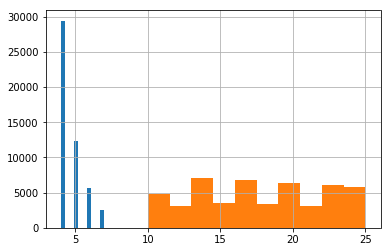

In [17]:
kindle_reviews['summary_length'].hist()
kindle_reviews['review_length'].hist()

In [18]:
kindle_reviews.head()

,review,summary,summary_length,review_length
index,,,,
6,enjoyed tho i am not sure it is called amy brewster mystery she is not much clean written characters drawn,nice old fashioned story,4,20
17,written ebook troy denning is not balance point written belongs new jedi order just do not think stand alone fun fast read kindle not paperback,star wars new jedi order recovery,6,25
20,excellent written story exciting lots action bad guys trying kill leia han viki shesh introduced,fits right new jedi order timeline,6,15
40,ebook reads kindle really does not belong is maybe end dark nest trilogy legacy force just not place belongs star wars universe not me,star wars fool s bargain,5,24
57,like louis l amour s books no exception want 6 words words words words words words words,good l l read,4,17


In [19]:
kindle_reviews.review_length.describe()

count    49985.000000
mean        17.533160
std          4.424578
min         10.000000
25%         14.000000
50%         17.000000
75%         21.000000
max         25.000000
Name: review_length, dtype: float64

In [20]:
tokenize = Tokenizer(num_words = RNN_VOCAB, oov_token='OOV')
tokenize.fit_on_texts(np.hstack([kindle_reviews['summary'],kindle_reviews['review']]))
kindle_reviews['sequence_summary'] = tokenize.texts_to_sequences(kindle_reviews['summary'])
kindle_reviews['sequence_review'] = tokenize.texts_to_sequences(kindle_reviews['review'])

In [21]:
#reviews = kindle_reviews.loc[kindle_reviews['sequence_summary'].apply(lambda x: not(1 in x))]

In [22]:
reviews.shape

NameError: name 'reviews' is not defined

In [23]:
#reviews = kindle_reviews.loc[kindle_reviews['sequence_review'].apply(lambda x: not(1 in x))]

In [24]:
kindle_reviews.shape

(49985, 6)

In [25]:
kindle_reviews = kindle_reviews.head(DATASET_SIZE)

In [26]:
kindle_reviews.shape

(40000, 6)

In [27]:
tokenize.word_index['EOS'] = RNN_VOCAB+2   #End of the sentence token
tokenize.word_index['SOS'] = RNN_VOCAB+1   #Start of the sentence token

In [28]:
kindle_reviews['sequence_summary'] += [tokenize.word_index['EOS']]

#Decoder input is one timestep ahead of decoder oupput 
kindle_reviews['sequence_summary_decoder_input'] = [tokenize.word_index['SOS']] + kindle_reviews['sequence_summary']

In [29]:
dataset = {}
dataset['decoder_input'] = pad_sequences(kindle_reviews.sequence_summary, maxlen = MAX_SEQUENCE_SUMMARY_LENGTH, padding='post')
dataset['decoder_output'] = pad_sequences(kindle_reviews.sequence_summary_decoder_input, maxlen = MAX_SEQUENCE_SUMMARY_LENGTH-1, padding='post')
dataset['encoder_input'] = pad_sequences(kindle_reviews.sequence_review, maxlen = MAX_SEQUENCE_REVIEW_LENGTH, padding='pre')

In [30]:
dataset['decoder_input'].shape

(40000, 9)

In [31]:
dataset['decoder_output'].shape

(40000, 8)

In [32]:
dataset['encoder_input'].shape

(40000, 25)

In [33]:
# Decoder output will be one hot encoded values 
# dimensions of the decoder output will be (number of samples * summary length * vocab size)

decoder_target_output = np.zeros((DATASET_SIZE, MAX_SEQUENCE_SUMMARY_LENGTH, RNN_VOCAB+3), dtype = 'float16')
for k, row in enumerate(dataset['decoder_output']):
    for i,value in enumerate(row):
        if value!=0:
            decoder_target_output[k,i,value] = 1

In [34]:
np.nonzero(decoder_target_output[0:2, : ,0:10003])

(array([0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1]),
 array([0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 5, 6, 7]),
 array([10001,    44,   123,  1445,     4, 10002, 10001,   249,  1997,
           36,  9873,   258,  4709, 10002]))

In [35]:
class Embeddings:
    """
    When a corpus is passed, remove the words which are not in the global vocab(glove) and use most frequent vocab_size
    number of words. 
    """
    def __init__(self, embedding_dim, vocab_size):
        self.embedding_dim = embedding_dim
        self.vocab_size = vocab_size
        
    def readEmbeddings(self, filePath):
        """
        Given a filepath of word embeddings creates and returns a dictionary of word, embedding values
        """
        # Create a dictionary for storing all {word, embedding values}
        wordToEmbeddingDict = {}
        # open the file as read only
        file = open(filePath, encoding='utf-8')
        # read all text
        for line in file:
            lineValue = line.split()
            word = lineValue[0]
            embedding = np.asarray(lineValue[1:],dtype = 'float32')
            wordToEmbeddingDict[word] = embedding
        # close the file
        file.close()
        return wordToEmbeddingDict
    
    def indexToEmbedding(self, wordToIndexDict, wordToEmbeddingDict):
        indexToEmbeddingMatrix = np.zeros((self.vocab_size+3, self.embedding_dim))
        for word, index in wordToIndexDict.items():
            if index > self.vocab_size+2:
                break
            if word in wordToEmbeddingDict.keys():
                indexToEmbeddingMatrix[index] = wordToEmbeddingDict[word]
            else:
                indexToEmbeddingMatrix[index] = np.array(np.random.uniform(-1.0, 1.0, self.embedding_dim))
        return indexToEmbeddingMatrix
    
    def indexToWord(self, wordToIndexDict):
        return {index: word for word, index in wordToIndexDict.items()}

In [36]:
embeddings = Embeddings(EMBEDDING_DIM, RNN_VOCAB)
wordToEmbeddingDict = embeddings.readEmbeddings(EMBEDDING_FILE_PATH)

indexToEmbeddingMatrix = embeddings.indexToEmbedding(tokenize.word_index, wordToEmbeddingDict)

In [37]:
indexToWordDict = embeddings.indexToWord(tokenize.word_index)

In [38]:
indexToEmbeddingMatrix.shape

(10003, 50)

In [39]:
from keras import optimizers

In [40]:
review_input_layer = Input(shape=(MAX_SEQUENCE_REVIEW_LENGTH, ), name = 'review')
embedding_encoder_layer = Embedding(input_length = MAX_SEQUENCE_REVIEW_LENGTH,
                        input_dim = RNN_VOCAB+3,
                        output_dim = EMBEDDING_DIM,
                        weights=[indexToEmbeddingMatrix],
                        trainable=False,
                        name = 'embedding_ENCODER')
embedding_review_output = embedding_encoder_layer(review_input_layer)
encoder_lstm_layer = LSTM(LATENT_DIM, return_state=True, name = 'lstm_encoder')
_, state_h, state_c = encoder_lstm_layer(embedding_review_output)
encoder_states = [state_h, state_c]

summary_input_layer = Input(shape=(MAX_SEQUENCE_SUMMARY_LENGTH, ), name = 'summary')

embedding_decoder_layer = Embedding(#input_length = MAX_SEQUENCE_SUMMARY_LENGTH,
                        input_dim = RNN_VOCAB+3,
                        output_dim = EMBEDDING_DIM,
                        weights=[indexToEmbeddingMatrix],
                        trainable=False,
                        name = 'embedding_DECODER')
embedding_summary_output = embedding_decoder_layer(summary_input_layer)
decoder_lstm_layer = LSTM(LATENT_DIM, return_state=True, return_sequences = True, name = 'lstm_decoder')
decoder_softmax_output, decoder_h, decoder_c = decoder_lstm_layer(embedding_summary_output,
                                                   initial_state = encoder_states)
decoder_dense_layer = Dense(RNN_VOCAB+3, activation="softmax", name='decoder_dense_layer')
decoder_dense_output =  decoder_dense_layer(decoder_softmax_output)
model = Model([review_input_layer, summary_input_layer], decoder_dense_output) 

sgd = optimizers.RMSprop(lr=0.0001, rho=0.9, epsilon=None, decay=0.0)

model.compile(optimizer='rmsprop', loss='categorical_crossentropy')

Instructions for updating:
Colocations handled automatically by placer.


In [41]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True)

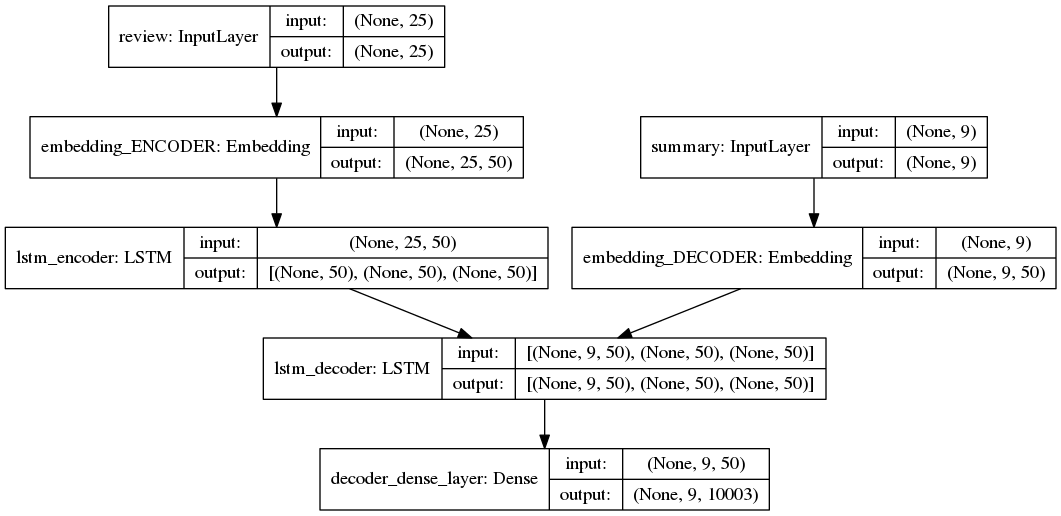

In [42]:
from IPython.display import Image
Image(filename='model.png') 

In [43]:
model.fit([dataset['encoder_input'], dataset['decoder_input']], decoder_target_output,
          batch_size=256,
          epochs=10
          )

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Epoch 1/10
40000/40000 [==============================] - 50s 1ms/step - loss: 4.5511
Epoch 2/10
40000/40000 [==============================] - 47s 1ms/step - loss: 3.7454
Epoch 3/10
40000/40000 [==============================] - 47s 1ms/step - loss: 3.3549
Epoch 4/10
40000/40000 [==============================] - 47s 1ms/step - loss: 3.0757
Epoch 5/10
40000/40000 [==============================] - 47s 1ms/step - loss: 2.8292
Epoch 6/10
40000/40000 [==============================] - 47s 1ms/step - loss: 2.6019
Epoch 7/10
40000/40000 [==============================] - 47s 1ms/step - loss: 2.4078
Epoch 8/10
40000/40000 [==============================] - 47s 1ms/step - loss: 2.2426
Epoch 9/10
40000/40000 [==============================] - 47s 1ms/step - loss: 2.1029
Epoch 10/10
40000/40000 [==============================] - 47s 1ms/step - loss: 1.9820


In the inference model, we need to keep in mind following few things

First we will encode the sequence, the encoder's output is of no use thus it will be discarded, state_c and state_h will be used as initial state of decoder, same as training. 

Also decoder will receive one input of initial time step ('bos' token to get started)

Decoder inputs : [encoder states , 'bos']

1) decoder RNN will output one word at a time,(output dim :{ 1, 1, 10000}

2) from argmax index to word mapping could be used to find the output word,

For the next timestep we need the decoder's states as well as an output

3) Next we need to provide our decoder with the decoder states and the output word again

We need to encapsulate decoder in separate block, its input and output is because it is gonna run recursively


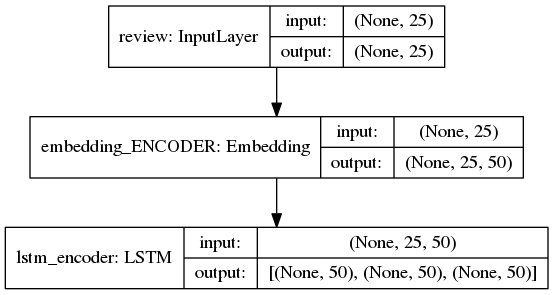

In [44]:
# Define inference model
encoder_inference_model = Model(review_input_layer, encoder_states)
plot_model(encoder_inference_model, to_file='inference_encoder.png', show_shapes=True)

Image(filename='inference_encoder.png') 

In [45]:
#Exactly same decoder model is used with different input and output adjustments

decoder_state_input_h = Input(shape=(LATENT_DIM,))  # These states are required for feeding back to our next timestep decoder
decoder_state_input_c = Input(shape=(LATENT_DIM,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

#Now we shall reuse our decoder
summary_for_decoder = Input(shape=(1,))
embedding_summary_decoder = embedding_decoder_layer(summary_for_decoder)

decoder_inference_output, decoder_states_c, decoder_states_h = decoder_lstm_layer(embedding_summary_decoder, initial_state = decoder_states_inputs)
decoder_states_outputs = [decoder_states_c, decoder_states_h]
output_prob = decoder_dense_layer(decoder_inference_output)
decoder_inference_model = Model(
    [summary_for_decoder] + decoder_states_inputs,
    decoder_states_outputs + [output_prob])

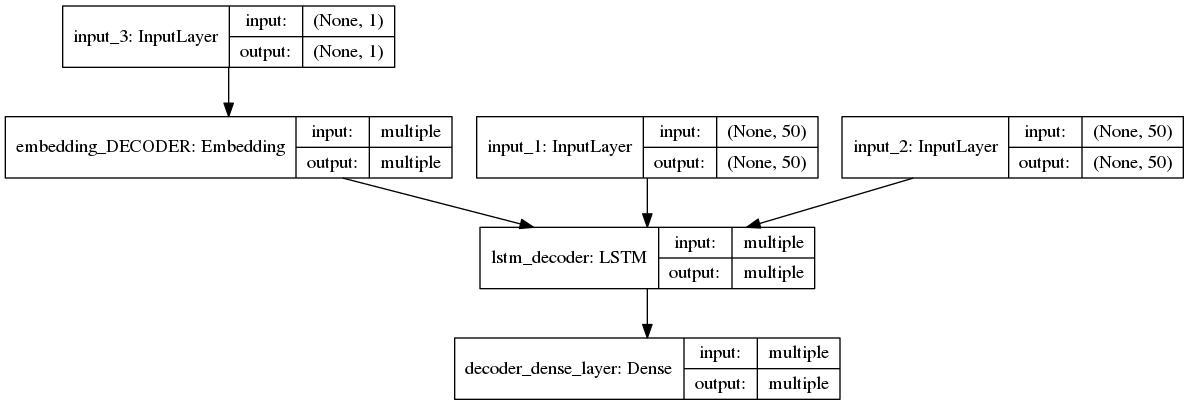

In [46]:
plot_model(decoder_inference_model, to_file='inference_decoder.png', show_shapes=True)

Image(filename='inference_decoder.png') 

In [47]:
import plotly.plotly as py
import plotly.graph_objs as go
import matplotlib.pyplot as plt


def decode_sequence(input_sequence):
    # Encode the input as state vectors. states_h and states_c for decoder init
    encoder_states_value = encoder_inference_model.predict(input_sequence)
    # Generate empty target sequence of length 1, for decoder input  
        
    # Populate the first character of target sequence with the start character.
        
    target_sequence = np.zeros((1,1))
    target_sequence[0,0] = tokenize.word_index['SOS']
    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = []
   
    while not stop_condition:
      
        h, c, output_tokens = decoder_inference_model.predict([target_sequence] + encoder_states_value,batch_size=1)
        # Sample a token
        
        sampled_word_index = np.random.choice(np.arange(10003), p=output_tokens.flatten())
        sampled_word = indexToWordDict[sampled_word_index]
        decoded_sentence += [sampled_word]
        
        #n, bins, patches = plt.hist(output_tokens.flatten(),bins=100)
        #plt.show()

        #sampled_word_index = np.argmax(output_tokens)
        #sampled_word = indexToWordDict[sampled_word_index]
        #decoded_sentence += [sampled_word]
        
        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_word == 'EOS' or
           len(decoded_sentence) > MAX_SEQUENCE_SUMMARY_LENGTH):
            stop_condition = True

        # Update the target sequence (of length 1).
            #target_sequence = np.zeros((1, 1, RNN_VOCAB+3))
            #target_sequence[0, 0, sampled_word_index] = 1.
            target_sequence[0, 0] = sampled_word_index
        # Update states
        encoder_states_value = [h, c]
       

    return decoded_sentence,

In [48]:
#for seq_index in np.arange(10):
    # Take one sequence (part of the training set)
    # for trying out decoding.
    # input_seq = pad_sequences(tokenize.texts_to_sequences(["i loved the book very well written will read again"]),17)
    # decoded_sentence = decode_sequence(input_seq)
    # print('-')
    # print('Input sentence:')
    # print('Decoded sentence:', decoded_sentence)

## Try it !

In [49]:
input_seq = pad_sequences(tokenize.texts_to_sequences([clean_text("i loved the book very well written will read again nice read")]),25)
input_seq
decode_sequence(input_seq)

(['SOS',
  'porn',
  'seattle',
  'thirst',
  'superb',
  'crush',
  'creek',
  'glitches',
  'wings',
  'patchwork'],)

In [50]:
input_seq = pad_sequences(tokenize.texts_to_sequences([clean_text("very very very bad book")]),25)
decode_sequence(input_seq)

(['SOS',
  'dane',
  'dusty',
  'easter',
  'amish',
  'soul',
  'vivid',
  'rhymes',
  'families',
  '9w'],)

In [51]:
input_seq = pad_sequences(tokenize.texts_to_sequences([clean_text("very very very very very very very very bad book")]),25)
decode_sequence(input_seq)

(['SOS',
  'amish',
  'speak',
  'emma',
  'kindle',
  'christmas',
  'nutrition',
  'fireman',
  'spear',
  'sheep'],)

In [52]:
# 1. try cudnn lstm
# 2. attention
# 3. beam search